In [1]:
%matplotlib notebook 

To compare average speed of fruit fly larvae and adult take the data of the control experiments and calculate speed.

In addition, it might be more useful to get the peak speed. To be stable against outliers, I'll take the median of the top 10% of speed from each animal.

In [2]:
import os
from pathlib import Path
import glob
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

In [3]:
home_path = os.getcwd()

In [4]:
def signal_filter(x_data, y_data, win_size, filter_name, pxmm, fps):
        if filter_name == 'Savitzky-Golay':
            x = savgol_filter(x_data.dropna(), win_size, 2)
            y = savgol_filter(y_data.dropna(), win_size, 2)
        else:
            x = x_data.rolling(window=win_size, win_type=filter_name).mean()
            y = y_data.rolling(window=win_size, win_type=filter_name).mean()


        speed = np.zeros(x_data.shape[0])
        for i in range(1, speed.shape[0]):
            try:
                # ((px/frames) / (px/mm)) * frames/second = mm/second
                speed[i] = (np.linalg.norm(np.array(x[i], y[i]) - np.array(x[i-1], y[i-1])) / pxmm) * fps
            except IndexError:
                pass
        return(speed)

In [5]:
os.chdir(home_path)
data_path_paraffin_ctr = Path('Figure 2/data/MS74xMS133/subsample/Paraffin/')
os.chdir(data_path_paraffin_ctr)
folders = [p.replace('\\', '') for p in glob.glob('*/')]
mean_speed_larva = np.zeros((len(folders)))
median_speed_larva = np.zeros((len(folders)))
median_ninety_percentile_larva = np.zeros((len(folders)))
    
# rough guess on how fast the larvae moves - helps with the filtering
mm_per_second = 1

In [6]:
for i in range(len(folders)):
    os.chdir(home_path)
    os.chdir(data_path_paraffin_ctr)
    os.chdir(folders[i])
    # read data
    files = [p.replace('\\', '') for p in glob.glob('*')]
    # get the arena
    for j in range(len(files)):
        if 'data.csv' in files[j]:
            data = pd.read_csv(files[j])
    with open(('experiment_settings.json'), 'r') as file:
        experiment_settings = json.load(file)
        pixel_per_mm = experiment_settings['Pixel per mm']
        recording_time = experiment_settings['Recording time']
        fps = experiment_settings['Framerate']
        
    # window size should always be odd as to not shift the value
    if int(fps/(mm_per_second*pixel_per_mm)) % 2 == 0:
        # even
        final_window_size = int((fps/(mm_per_second*pixel_per_mm)) + 1)
    else:
        # odd
        final_window_size = int(fps/(mm_per_second*pixel_per_mm))

    tail_speed_filt = signal_filter(data['X-Tail'], data['Y-Tail'], final_window_size, 'triang', pixel_per_mm, fps)
    tail_speed_filt_pd = pd.Series(tail_speed_filt)
    tail_speed_2x_filt_pd = tail_speed_filt_pd.rolling(window=fps, win_type='triang').mean()
    mean_speed_larva[i] = np.nanmean(tail_speed_2x_filt_pd)
    median_speed_larva[i] = np.nanmedian(tail_speed_2x_filt_pd)
    
    ninety_percentile_larva = np.nanpercentile(tail_speed_2x_filt_pd, 90)
    median_ninety_percentile_larva[i] = np.nanmedian(
        tail_speed_2x_filt_pd[tail_speed_2x_filt_pd>ninety_percentile_larva])
 
mean_larval_speed = np.nanmean(mean_speed_larva)
peak_larval_speed = np.nanmedian(median_ninety_percentile_larva)

In [7]:
os.chdir(home_path)
data_path_adult = Path('Figure 3/data/empty-Gal4xUAS-Chrimson/')
os.chdir(data_path_adult)
folders = [p.replace('\\', '') for p in glob.glob('*/')]
mean_speed_adult = np.zeros((len(folders)))
median_speed_adult = np.zeros((len(folders)))
median_ninety_percentile_adult = np.zeros((len(folders)))

In [8]:
for i in range(len(folders)):
    #print(i)
    os.chdir(home_path)
    os.chdir(data_path_adult)
    os.chdir(folders[i])

    # find the data_file.csv 
    files = [p.replace('\\', '') for p in glob.glob('*')]
    for file in files:
        if 'data.csv' in file:
            data = pd.read_csv(file)
    with open(('experiment_settings.json'), 'r') as file:
        experiment_settings = json.load(file)
        pixel_per_mm = experiment_settings['Pixel per mm']
        recording_time = experiment_settings['Recording time']
        fps = experiment_settings['Framerate']
        
    # rough guess on how fast the fly moves - helps with the filtering
    mm_per_second = 5
    # window size should always be odd as to not shift the value
    if int(fps/(mm_per_second*pixel_per_mm)) % 2 == 0:
        # even
        final_window_size = int((fps/(mm_per_second*pixel_per_mm)) + 1)
    else:
        # odd
        final_window_size = int(fps/(mm_per_second*pixel_per_mm))

    centroid_speed_filt = signal_filter(data['X-Centroid'], data['Y-Centroid'], final_window_size, 'triang', pixel_per_mm, fps)
    centroid_speed_filt_pd = pd.Series(centroid_speed_filt)
    centroid_speed_2x_filt_pd = centroid_speed_filt_pd.rolling(window=fps, win_type='triang').mean()
    mean_speed_adult[i] = np.nanmean(centroid_speed_2x_filt_pd)
    median_speed_adult[i] = np.nanmedian(centroid_speed_2x_filt_pd)
    ninety_percentile_adult = np.nanpercentile(centroid_speed_2x_filt_pd, 90)
    median_ninety_percentile_adult[i] = np.nanmedian(centroid_speed_2x_filt_pd[centroid_speed_2x_filt_pd>ninety_percentile_adult])
    
mean_adult_speed = np.nanmean(mean_speed_adult)
peak_adult_speed = np.nanmedian(median_ninety_percentile_adult)

In [9]:
print("Peak larval speed: " + repr(peak_larval_speed))
print("Peak adult speed: " + repr(peak_adult_speed))

Peak larval speed: 1.5420854271356783
Peak adult speed: 12.451420029895367


<IPython.core.display.Javascript object>


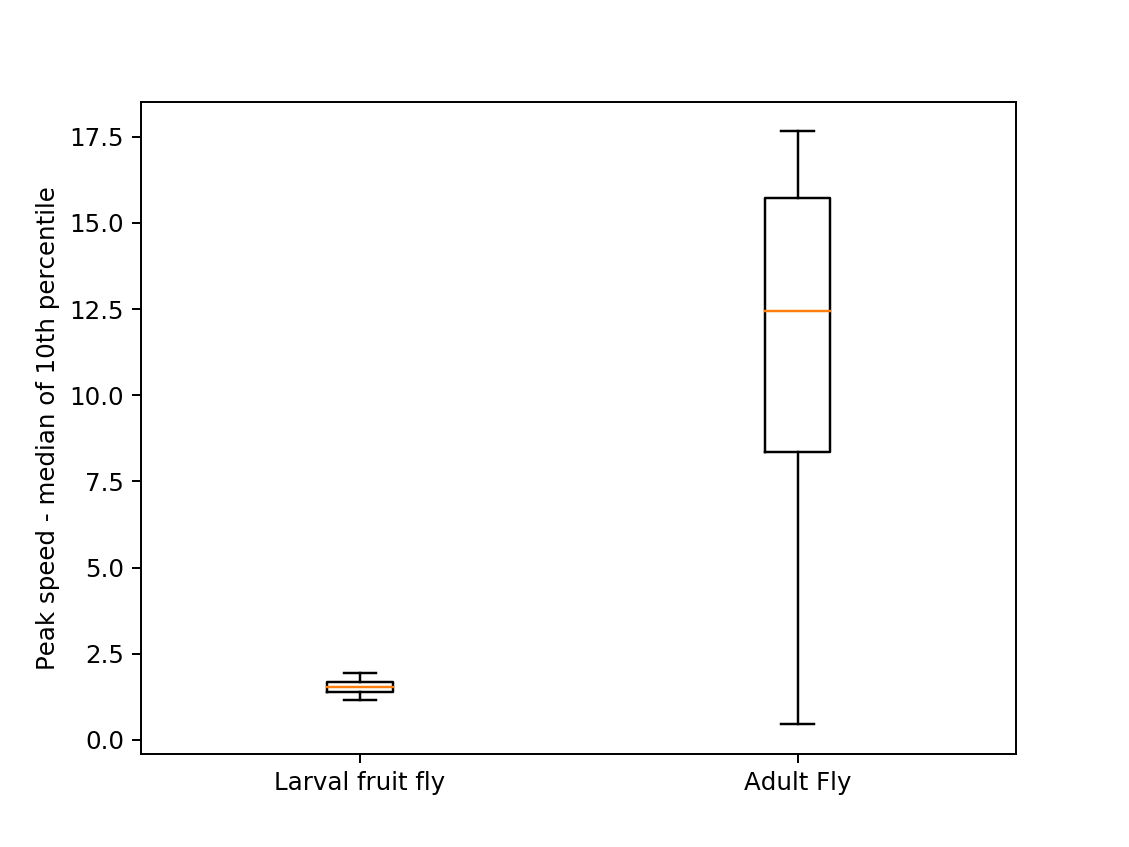

[Text(0, 0, 'Larval fruit fly'), Text(0, 0, 'Adult Fly')]

In [10]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.boxplot([median_ninety_percentile_larva, median_ninety_percentile_adult])
ax.set_ylabel('Peak speed - median of 10th percentile')
ax.set_xticklabels(['Larval fruit fly', 'Adult Fly'])